In [3]:
!pip install --upgrade pip
!pip install wheel
!sudo apt-get update
!sudo apt-get install gfortran -y
!sudo apt install make -y
!pip install camb
!pip install healpy
!pip install seaborn
!pip install tqdm

Get:1 file:/etc/apt/mirrors/debian.list Mirrorlist [30 B]
Get:2 file:/etc/apt/mirrors/debian-security.list Mirrorlist [39 B]
Get:7 https://packages.cloud.google.com/apt google-compute-engine-bookworm-stable InRelease [5146 B]
Hit:8 https://packages.cloud.google.com/apt cloud-sdk-bookworm InRelease       
Hit:3 https://deb.debian.org/debian bookworm InRelease  
Hit:4 https://deb.debian.org/debian bookworm-updates InRelease
Hit:5 https://deb.debian.org/debian bookworm-backports InRelease
Hit:6 https://deb.debian.org/debian-security bookworm-security InRelease
Fetched 5146 B in 1s (9164 B/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gfortran is already the newest version (4:12.2.0-3).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
make is already the newest version (4.3-4.1).
0 upgraded, 0 newl

## MOPED with noise

In [28]:
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import camb
from tqdm import tqdm
import healpy as hp
warnings.filterwarnings("ignore")
'''
theta = [h0, ombh2, omch2, logAs, ns]
where As = 1e-10np.exp(logAs)
'''
def sim(theta, cls = True):
    hubble = theta[0]*100
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=hubble, ombh2=theta[1])
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
    cl = powers['total'][:, 0]
    return cl[2:2500]

fiducial_values = [0.674,  0.0224]
finite_param_steps = [0.0025, 0.0002]
fiducial_cls = sim(fiducial_values, cls = False)

def finite_derivative_calc_update(fiducial_vals, size):
    derivatives = []
    for i in tqdm(range(2)):
        step = size[i]
        parr = fiducial_vals.copy()
        parr[i] = fiducial_vals[i] + step
        parr2 = fiducial_vals.copy()
        parr2[i] = fiducial_vals[i] - step
        cl1 = sim(parr, cls = False)
        cl2 = sim(parr2, cls = False)
        derivative = (cl1 - cl2)/(2*step)
        derivatives.append(derivative.tolist())
    return derivatives

finite_derivative = finite_derivative_calc_update(fiducial_values, finite_param_steps)
finite_derivative = np.array(finite_derivative)
def cov_matrix(vals):
    ells = np.arange(2501)[2:2500]
    V = np.diag(vals**2)*2 / ((2*ells+1))
    return V

def MOPED(obs):
    obs = obs
    d_minus_mu = obs - fiducial_cls
    d_minus_mu_vector = [[i] for i in d_minus_mu ]
    inverse_cov_matrix = np.linalg.inv(cov_matrix(obs))
    term1 = np.matmul(inverse_cov_matrix, d_minus_mu_vector)
    compressed_stat = np.matmul(finite_derivative, term1)
    result =  [item[0] for item in compressed_stat]
    return result, inverse_cov_matrix

@lru_cache(maxsize=64) 
def log_Likelihood_cached(theta_key):
    theta = np.array(theta_key)  
    return log_Likelihood_internal(theta)

def log_Likelihood(theta, data):
    theta_key = tuple(theta)
    return log_Likelihood_cached(theta_key)

def log_Likelihood_internal(theta):
    try:
        vals = sim(theta)
    except: 
        return -1e-25
    vals_comp, inv_mat = MOPED(vals)
    data_comp, inv_mat_data = MOPED(data)
    V = np.matmul(finite_derivative, np.matmul(inv_mat.T, finite_derivative.T))
    d_minus_mu = np.subtract(vals_comp, data_comp)
    e_factor = -0.5 * np.matmul(d_minus_mu.T, np.matmul(np.linalg.inv(V), d_minus_mu))
    factor = np.sqrt(2 * np.pi * np.linalg.norm(V))
    result = e_factor - np.log(factor)
    return result


data = sim([0.676, 0.0220, 0.122, 3.085, 0.964])

100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.39s/it]


In [9]:
print(len(finite_derivative[0]))

2498


In [29]:
def MH_sampler(M,N,theta_in,sigma):
    h_accepted = []
    ombh2_accepted = []
    acceptance_likelihood = []
    Naccepted = []

    for i in range(M):
        Naccept = 0
        h_accept = [theta_in[0][i]]
        ombh2_accept     = [theta_in[1][i]]
        acpt_lkhd    = []
        # theta_accept = np.array([alpha_accept, a_accept, b_accept, c_accept, d_accept, e_accept, f_accept])
        for j in tqdm(range(N)):  
            theta_accept = np.array([h_accept[-1], ombh2_accept[-1]])
            #Generating random values of h and Omega_m in range (0,1) with Gaussian proposal distribution
            h_random = np.random.normal(h_accept[-1], sigma[0]) 
            ombh2_random     = np.random.normal(ombh2_accept[-1], sigma[1])     
            theta_random = [h_random, ombh2_random]   

            #Calulating log of likelihood of these randomly generated 
            new_log_L = log_Likelihood(theta_random, data)

            '''
            calulating acceptance probability and taking minimum of 1 and ratio of likelihood of new value of parameters to
            previous accepted values. If the ratio of likelihood is increased then it is accepted without condition.
            But if the likelihood goes down in next step then it would be accepted with uniform probability.
            '''

            acc_lkh = min(np.exp(new_log_L - log_Likelihood(theta_accept, data)), 1)

            if np.random.uniform(0, 1) < acc_lkh:
                h_accept   = np.append(h_accept, h_random)
                ombh2_accept       = np.append(ombh2_accept, ombh2_random)
                acpt_lkhd           = np.append(acpt_lkhd, new_log_L)
                Naccept+=1

        h_accepted.append(h_accept)
        ombh2_accepted.append(ombh2_accept)
        acceptance_likelihood.append(acpt_lkhd)
        Naccepted.append(Naccept)
        theta_accepted = np.array([h_accepted, ombh2_accepted], dtype = object)
    Naccepted = np.array(Naccepted, dtype = object)
    acceptance_likelihood = np.array(acceptance_likelihood, dtype=object)
    return theta_accepted, acceptance_likelihood, Naccepted

In [27]:
print(log_Likelihood([0.80, 0.015], data))

[[ 1.37839084e+07 -1.80713337e+08]
 [-1.80713337e+08  2.80505788e+09]]
-324213.28791711066


In [45]:
M = 3
N = 3000
sigma = [0.004, 0.0001]
theta_in = np.array([[0.6, 0.8, 0.9],
                     [0.01, 0.015, 0.025]])
theta_accepted, acceptance_likelihood, Naccepted = MH_sampler(M,N,theta_in, sigma)
np.save(f'M_{M}_N_{N}_theta_accepted_moped.npy', theta_accepted)
np.save(f'M_{M}_N_{N}_acceptance_likelihood_moped.npy', acceptance_likelihood)
np.save(f'M_{M}_N_{N}_Naccepted_moped.npy', Naccepted)

  1%|▏                                      | 16/3000 [00:35<1:48:58,  2.19s/it]


KeyboardInterrupt: 

In [34]:
def gelman_rubin_diagnostic(param_chains):
    m = len(param_chains)
    n = np.array([len(chain) for chain in param_chains], dtype=np.float64)

    chain_means = np.array([np.mean(chain) for chain in param_chains])
    mean_of_chain_means = np.mean(chain_means)

    B = n[0] * np.sum((chain_means - mean_of_chain_means) ** 2) / (m - 1)

    W = np.sum([(np.var(chain, ddof=1)) for chain in param_chains]) / m

    var_hat = (n[0] - 1) / n[0] * W + B / n[0]

    R_hat = np.sqrt(var_hat / W)

    return R_hat

def estimate_burn_in_rhat(param_chains, threshold=1.1, min_samples=50, step=50):
    max_length = min([len(chain) for chain in param_chains])
    for length in range(min_samples, max_length, step):
        segment_chains = [chain[:length] for chain in param_chains]
        R_hat = gelman_rubin_diagnostic(segment_chains)
        if R_hat < threshold:
            return length
    return max_length

burn_in_estimates = []
for param_chains in theta_accepted:
    burn_in = estimate_burn_in_rhat(param_chains, threshold=2, min_samples=50, step=1)
    burn_in_estimates.append(burn_in)

print("Estimated burn-in for each parameter:", burn_in_estimates)
print("Nburn set to :", max(burn_in_estimates))
print 

Nburn = max(burn_in_estimates)

Estimated burn-in for each parameter: [112, 126]
Nburn set to : 126


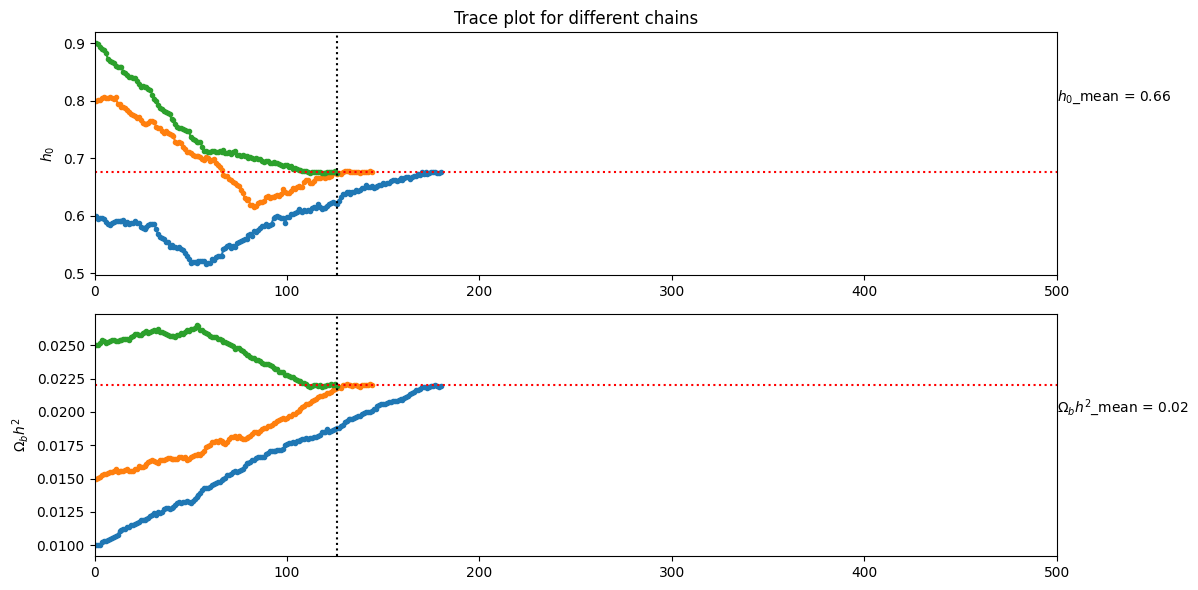

In [43]:
Nburn = 126
M = 3
h_all = []
ombh2_all     = []
acc_all   = []
for i in range(M):
    h_all = np.append(theta_accepted[0][i][Nburn+1:], h_all)
    ombh2_all = np.append(theta_accepted[1][i][Nburn+1:], ombh2_all)
    acc_all = np.append(acceptance_likelihood[i][Nburn:], acc_all)

xlim = N
# Plotting Trace plot for Omega_m and h for all the cains
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(12,6))
ax0.set_xlim(0,xlim)
ax0.set_ylabel(r"$h_0$")
for i in range(M):
    ax0.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[0][i],marker='.')
ax0.axvline(Nburn, color='black', linestyle=':')
ax0.axhline(0.676, color='red', linestyle=':')
ax0.text(500, 0.8, r'$h_0$_mean = {}'.format(np.round(np.mean(h_all),2)))
ax0.set_title("Trace plot for different chains")

ax1.set_ylabel("$\Omega_b h^2$")
for i in range(M):
    ax1.plot(np.arange(1, Naccepted[i]+2, 1), theta_accepted[1][i],marker='.')
ax1.axvline(Nburn, color='black', linestyle=':')
ax1.axhline(0.0220, color='red', linestyle=':')
ax1.text(500, 0.02, r'$\Omega_b h^2$_mean = {}'.format(np.round(np.mean(ombh2_all),2)))
ax1.set_xlim(0,xlim)

plt.tight_layout()
#plt.savefig('mcmc_3000_5.pdf')
plt.show()

In [36]:
def gelman_rubin_test(M,N,q):
    #Between-Chain Variance
    h_mean_each_chain = np.array([np.mean(q[m]) for m in range(M)])
    theta_hat_h = np.mean(h_mean_each_chain)
    B_h = (N/(M-1))*np.sum((h_mean_each_chain - theta_hat_h)**2)

    #within Chain Variance
    h_var_each_chain = np.array([np.var(q[m]) for m in range(M)])
    W_h = np.mean(h_var_each_chain)

    #Estimators
    var_minus_h = W_h
    var_plus_h = ((N - 1)/N)* W_h + ((M+1)/(M*N))*B_h

    #Test
    R_hat_h = np.sqrt(var_plus_h / var_minus_h)

    return R_hat_h

h_all_chains = []
for i in range (M):
    h_all_chains.append(theta_accepted[0][i][Nburn:])
R_hat_h = gelman_rubin_test(M,N, h_all_chains)
print(f'''
R_hat for h_0        = {R_hat_h}
''')


R_hat for h_0        = nan



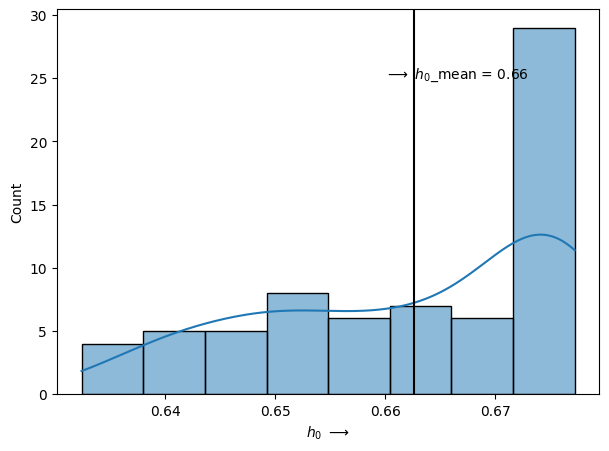

In [40]:
plt.figure(figsize=(7,5), dpi = 100)
sns.histplot(h_all, kde=True,common_norm=True)
plt.xlabel(r'$h_0$ $\longrightarrow$')
plt.text(np.round(np.mean(h_all),2), 25, r'$\longrightarrow$ $h_0$_mean = {}'.format(np.round(np.mean(h_all),2)))
plt.axvline(np.mean(h_all), c='black')
plt.show()

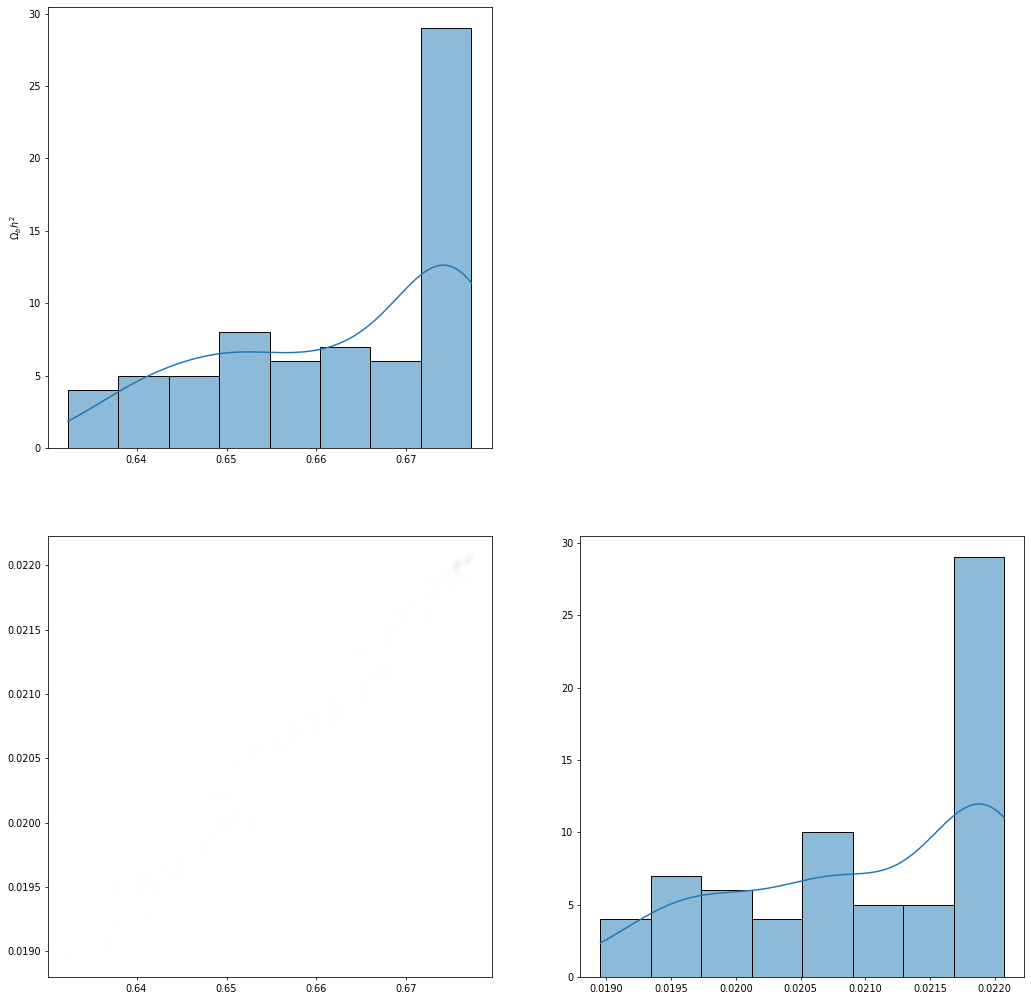

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(18,18), dpi=70)

sns.histplot(h_all, ax=ax[0,0], kde=True)
# ax[0,0].hist(alpha_all*19.8,bins=30)
ax[0,0].set_ylabel(r'$h_0$')

ax[1,0].scatter(h_all,ombh2_all,c=-np.exp(acc_all),cmap='magma',alpha=0.01)
ax[0,0].set_ylabel('$\Omega_b h^2$')

sns.histplot(ombh2_all, ax=ax[1,1], kde=True)
ax[1,1].set_ylabel(None)

fig.delaxes(ax[0,1])

plt.show()

In [80]:
new_theta_in = np.array([[theta_accepted[0][i][-1] for i in range(M)],
                        [theta_accepted[1][i][-1] for i in range(M)]])

M = 3
N = 1000
sigma = [0.004, 0.0001]
theta_accepted_new, acceptance_likelihood_new, Naccepted_new = MH_sampler(M,N,new_theta_in, sigma)
np.save(f'M_{M}_N_{N}_theta_accepted_moped_v2.npy', theta_accepted_new)
np.save(f'M_{M}_N_{N}_acceptance_likelihood_moped_v2.npy', acceptance_likelihood_new)
np.save(f'M_{M}_N_{N}_Naccepted_moped_v2.npy', Naccepted_new)

100%|███████████████████████████████████████| 1000/1000 [34:16<00:00,  2.06s/it]


In [83]:
theta_accepted = np.array(theta_accepted, dtype = object)
acceptance_likelihood = np.array(acceptance_likelihood, dtype = object)
Naccepted = np.array(Naccepted, dtype = object)

In [84]:
np.save(f'M_{M}_N_{N}_theta_accepted_moped_comb1.npy', theta_accepted)
np.save(f'M_{M}_N_{N}_acceptance_likelihood_moped_comb1.npy', acceptance_likelihood)
np.save(f'M_{M}_N_{N}_Naccepted_moped_comb1.npy', Naccepted)

In [85]:
theta_accepted_1k = np.load('M_3_N_1000_theta_accepted_moped_v2.npy', allow_pickle=True)
Naccepted_1k = np.load('M_3_N_1000_Naccepted_moped_v2.npy', allow_pickle=True)
acceptance_likelihood_1k = np.load('M_3_N_1000_acceptance_likelihood_moped_v2.npy', allow_pickle=True)

theta_accepted_500 = np.load('M_3_N_1000_theta_accepted_moped_comb1.npy', allow_pickle = True)
Naccepted_500 = np.load('M_3_N_1000_Naccepted_moped_comb1.npy', allow_pickle = True)
acceptance_likelihood_500 = np.load('M_3_N_1000_acceptance_likelihood_moped_comb1.npy', allow_pickle=True)

In [86]:
theta_accepted = []
for j in range(2): #each param
    pars = []
    for i in range(3): #each chain
        if i != 6:
            pars.append(np.concatenate((theta_accepted_500[j][i], theta_accepted_1k[j][i])))
    theta_accepted.append(pars)
print(len(theta_accepted[0][0]))

acceptance_likelihood = []
for i in range(3):
    if i != 6:
        acceptance_likelihood.append(np.concatenate((acceptance_likelihood_500[i], acceptance_likelihood_1k[i])))
print([len(acceptance_likelihood[i]) for i in range(3)])

Naccepted = []
for i in range(3):
    if i != 6:
        Naccepted.append(Naccepted_500[i]+Naccepted_1k[i])
print(Naccepted)


378
[375, 326, 284]
[375, 326, 284]


In [87]:
def gelman_rubin_diagnostic(param_chains):
    m = len(param_chains)
    n = np.array([len(chain) for chain in param_chains], dtype=np.float64)

    chain_means = np.array([np.mean(chain) for chain in param_chains])
    mean_of_chain_means = np.mean(chain_means)

    B = n[0] * np.sum((chain_means - mean_of_chain_means) ** 2) / (m - 1)

    W = np.sum([(np.var(chain, ddof=1)) for chain in param_chains]) / m

    nmin = min(n)
    var_hat = (nmin - 1) / nmin * W + B / nmin

    R_hat = np.sqrt(var_hat / W)
    #print(var_hat, W)

    return R_hat

def estimate_burn_in_rhat(param_chains, threshold=1.1, min_samples=50, step=50):
    max_length = min([len(chain) for chain in param_chains])
    for length in range(min_samples, max_length, step):
        segment_chains = [chain[:length] for chain in param_chains]
        R_hat = gelman_rubin_diagnostic(segment_chains)
        if R_hat < threshold:
            return length
    return max_length

burn_in_estimates = []
for param_chains in theta_accepted:
    burn_in = estimate_burn_in_rhat(param_chains, threshold=2, min_samples=50, step=1)
    burn_in_estimates.append(burn_in)

print("Estimated burn-in for each parameter:", burn_in_estimates)
print("Nburn set to :", max(burn_in_estimates))

Nburn = max(burn_in_estimates)

Estimated burn-in for each parameter: [112, 154]
Nburn set to : 154


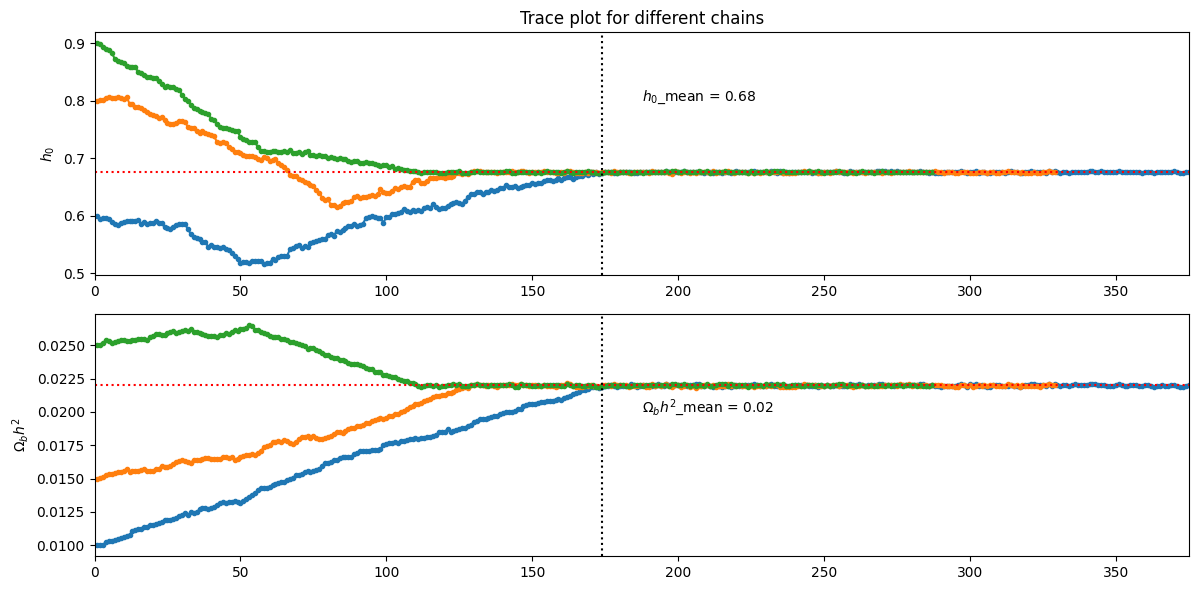

In [93]:
Nburn = 174
M = 3
h_all = []
ombh2_all     = []
acc_all   = []
for i in range(M):
    h_all = np.append(theta_accepted[0][i][Nburn+1:], h_all)
    ombh2_all = np.append(theta_accepted[1][i][Nburn+1:], ombh2_all)
    acc_all = np.append(acceptance_likelihood[i][Nburn-2:], acc_all)

xlim = max(Naccepted)
x_pos = xlim/2
# Plotting Trace plot for Omega_m and h for all the cains
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(12,6))
ax0.set_xlim(0,xlim)
ax0.set_ylabel(r"$h_0$")
for i in range(M):
    ax0.plot(np.arange(1, Naccepted[i]+4, 1), theta_accepted[0][i],marker='.')
ax0.axvline(Nburn, color='black', linestyle=':')
ax0.axhline(0.676, color='red', linestyle=':')
ax0.text(x_pos, 0.8, r'$h_0$_mean = {}'.format(np.round(np.mean(h_all),2)))
ax0.set_title("Trace plot for different chains")

ax1.set_ylabel("$\Omega_b h^2$")
for i in range(M):
    ax1.plot(np.arange(1, Naccepted[i]+4, 1), theta_accepted[1][i],marker='.')
ax1.axvline(Nburn, color='black', linestyle=':')
ax1.axhline(0.0220, color='red', linestyle=':')
ax1.text(x_pos, 0.02, r'$\Omega_b h^2$_mean = {}'.format(np.round(np.mean(ombh2_all),2)))
ax1.set_xlim(0,xlim)

plt.tight_layout()
#plt.savefig('mcmc_3000_5.pdf')
plt.show()

In [91]:
rhats = []
for param_chains in theta_accepted:
    rhat = gelman_rubin_diagnostic(param_chains)
    rhats.append(rhat)

print("Rhat for each parameter:",rhats)
print("Max Rhat :", max(rhats))

Rhat for each parameter: [1.2786831171540132, 1.295596483876205]
Max Rhat : 1.295596483876205


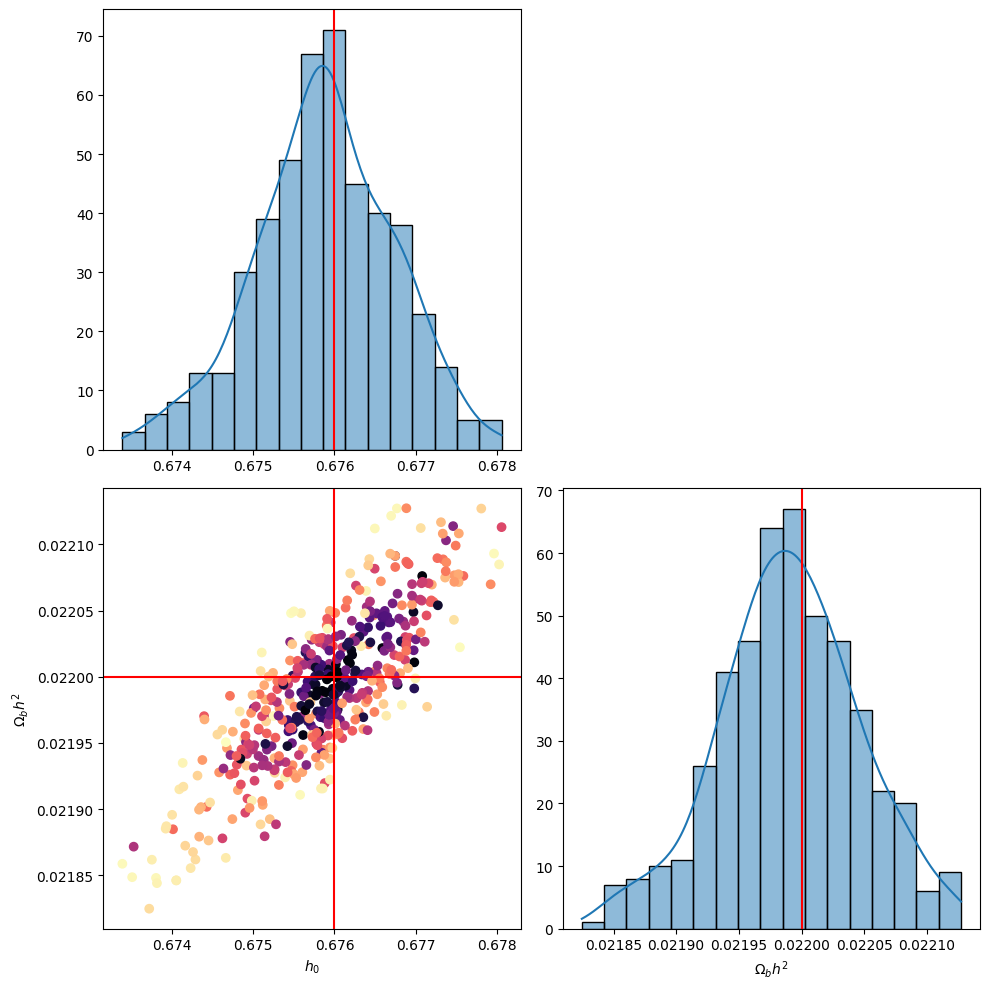

In [102]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(h_all, ax=ax[0,0], kde=True)
# ax[0,0].hist(alpha_all*19.8,bins=30)
ax[0,0].axvline(0.676, color='red')
ax[0,0].set_ylabel(None)

ax[1,0].scatter(h_all,ombh2_all,c=-np.exp(acc_all),cmap='magma')
ax[1,0].set_ylabel('$\Omega_b h^2$')
ax[1,0].set_xlabel(r'$h_0$')
ax[1,0].axhline(0.0220, color='red')
ax[1,0].axvline(0.676, color='red')

sns.histplot(ombh2_all, ax=ax[1,1], kde=True)
ax[1,1].set_ylabel(None)
ax[1,1].axvline(0.0220, color='red')
ax[1,1].set_xlabel('$\Omega_b h^2$')

fig.delaxes(ax[0,1])
plt.tight_layout()
plt.savefig('mcmc_moped_no_noise_2param.pdf')
plt.show()